In [1]:
%load_ext lab_black
import numpy as np
import uproot as up
from matplotlib import pyplot as plt
from ipynb.fs.defs.covfit import *
from scipy.stats import chi2

In [2]:
# Load the data

# Data from https://arxiv.org/abs/1002.2680 and https://arxiv.org/abs/1301.7067

files = {
    "Genie": "MB_CC0pi_GENIEv3.00.06.root",
    "Neut": "MB_CC0pi_NEUTv5.4.1.root",
    "Nuwro": "MB_CC0pi_NUWROv19.02.2.root",
}

modes = ["nu", "antinu"]

data = {}
MC = {}
MC_scale = {}
var = {}
scale_error = {
    "nu": 0.107,
    "antinu": 0.130,
}
bin_width = {
    "nu": 0.01,  # 1/GeV
    "antinu": 0.01,  # 1/GeV
}

for gen, filename in files.items():
    F = up.open(filename)

    for mode in modes:
        hist = F[f"MiniBooNE_CCQELike_XSec_2DTcos_{mode}_data_1D"]
        data[mode] = hist.numpy()[0]

        cov = F[f"MiniBooNE_CCQELike_XSec_2DTcos_{mode}_COV"]
        var[mode] = np.diag(cov.numpy()[0]) * 1e-76

        hist = F[f"MiniBooNE_CCQELike_XSec_2DTcos_{mode}_MC_1D"]
        hist = hist.numpy()[0]
        scale = np.sum(data[mode]) / np.sum(hist)
        hist *= scale
        MC_scale[(mode, gen)] = scale
        MC[(mode, gen)] = hist

In [3]:
# Shape-only p-values
p_shape = {}
for mode in modes:
    for gen in files:
        z = np.sqrt((data[mode] - MC[(mode, gen)]) ** 2 / var[mode])
        p = {}
        p["naive"] = chi2(df=len(z)).sf(naive(z))
        p["fitted"] = BEE2(df=len(z)).sf(fitted(z))
        p["invariant"] = chi2(df=1).sf(invariant3(z, alpha=2 / 3))
        print(f"{mode} {gen}")
        print(p)
        p_shape[(mode, gen)] = p

nu Genie
{'naive': 0.026563815569466687, 'fitted': 0.041215837071184036, 'invariant': 0.0412099081963185}
nu Neut
{'naive': 9.421015322550512e-09, 'fitted': 0.01673936971796719, 'invariant': 0.01672307814418724}
nu Nuwro
{'naive': 0.00014426047897557264, 'fitted': 0.0824558757908358, 'invariant': 0.08243867896940472}
antinu Genie
{'naive': 9.113471795997956e-25, 'fitted': 1.9159893394404826e-05, 'invariant': 1.908649483599175e-05}
antinu Neut
{'naive': 6.8719519885395215e-15, 'fitted': 0.0004076420906432565, 'invariant': 0.0004061583649425962}
antinu Nuwro
{'naive': 2.2846381814624053e-26, 'fitted': 5.887116374792001e-05, 'invariant': 5.864678707110717e-05}


In [4]:
# Fitted scale shape-only p-values
from scipy.optimize import minimize

for mode in modes:
    for gen in files:

        def fun(scale):
            return np.sum((data[mode] - scale * MC[(mode, gen)]) ** 2 / var[mode])

        opt = minimize(fun, 1)
        z = np.sqrt((data[mode] - opt.x * MC[(mode, gen)]) ** 2 / var[mode])
        p = {}
        p["naive"] = chi2(df=len(z) - 1).sf(naive(z))
        p["fitted"] = BEE2(df=len(z)).sf(fitted(z))
        p["invariant"] = chi2(df=1).sf(invariant3(z, alpha=2 / 3))
        print(f"{mode} {gen}")
        print(p)

nu Genie
{'naive': 0.026341611794285166, 'fitted': 0.027721252927546458, 'invariant': 0.02771681897868312}
nu Neut
{'naive': 1.3504535090165254e-08, 'fitted': 0.006588459357810161, 'invariant': 0.006565352505763329}
nu Nuwro
{'naive': 0.00022002716981599522, 'fitted': 0.03407456308390466, 'invariant': 0.03405213141629351}
antinu Genie
{'naive': 4.7147328023972437e-20, 'fitted': 0.00033121307955430446, 'invariant': 0.00032999508530791956}
antinu Neut
{'naive': 1.3619051957788378e-11, 'fitted': 0.005604226848959559, 'invariant': 0.0055982055179359955}
antinu Nuwro
{'naive': 2.1380537164710563e-19, 'fitted': 0.001324303972840446, 'invariant': 0.0013200813759324072}


In [5]:
# Shape & scale p-values
p_full = {}
for mode in modes:
    for gen in files:
        z = np.append(
            np.sqrt((data[mode] - MC[(mode, gen)]) ** 2 / var[mode]),
            np.abs(1 - MC_scale[(mode, gen)]) / scale_error[mode],
        )
        p = {}
        p["naive"] = chi2(df=len(z)).sf(naive(z))
        p["fitted"] = BEE2(df=len(z)).sf(fitted(z))
        p["invariant"] = chi2(df=1).sf(invariant3(z, alpha=2 / 3))
        print(f"{mode} {gen}")
        print(p)
        p_full[(mode, gen)] = p

nu Genie
{'naive': 0.0012706146291711737, 'fitted': 0.0002492016912674089, 'invariant': 0.0002475329927871506}
nu Neut
{'naive': 8.655143835754127e-10, 'fitted': 0.016860519028386145, 'invariant': 0.01684399020368059}
nu Nuwro
{'naive': 3.673898700723168e-05, 'fitted': 0.08303203715623142, 'invariant': 0.08301459865331497}
antinu Genie
{'naive': 5.134122057718561e-27, 'fitted': 1.9405530669924786e-05, 'invariant': 1.933022816853988e-05}
antinu Neut
{'naive': 2.137382712231199e-15, 'fitted': 0.0004128671922857263, 'invariant': 0.0004113449815885766}
antinu Nuwro
{'naive': 5.595218676392797e-27, 'fitted': 5.96258997553889e-05, 'invariant': 5.9395702834787904e-05}


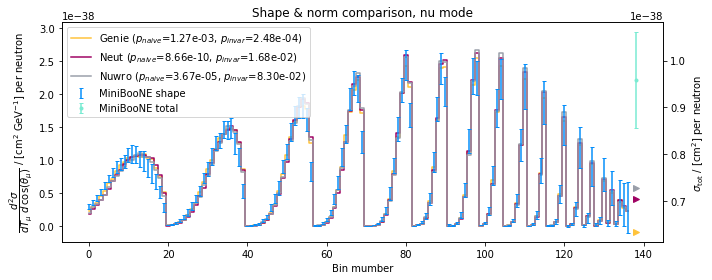

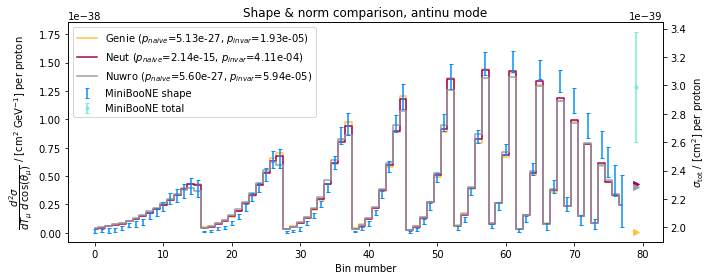

In [6]:
for mode in modes:
    fig, ax = plt.subplots(figsize=(10, 4))
    ax2 = ax.twinx()
    ax.errorbar(
        np.arange(len(data[mode])),
        data[mode],
        np.sqrt(var[mode]),
        linestyle="",
        label="MiniBooNE shape",
        zorder=5,
        capsize=2,
    )
    total = np.sum(data[mode]) * bin_width[mode]  # Bin width
    ax2.errorbar(
        [len(data[mode]) + 1],
        total,
        total * scale_error[mode],
        linestyle="",
        color="C5",
        marker=".",
        label="MiniBooNE total",
        zorder=5,
        capsize=2,
    )
    for gen in files:
        art = ax.step(
            np.arange(len(MC[(mode, gen)])),
            MC[(mode, gen)],
            where="mid",
            label=gen
            + f" ($p_{{naive}}$={p_full[(mode,gen)]['naive']:.2e}, $p_{{invar}}$={p_full[(mode,gen)]['invariant']:.2e})",
        )
        ax2.plot(
            [len(data[mode]) + 1],
            total / MC_scale[(mode, gen)],
            marker=">",
            linewidth=2,
            color=art[0].get_color(),
        )
    # ax.set_yscale("log")
    ax.set_ylim(top=ax.get_ylim()[1] * 1.1)
    ax.set_xlabel("Bin mumber")
    if mode == "nu":
        target = "neutron"
    else:
        target = "proton"
    ax.set_ylabel(
        r"$\dfrac{d^2 \sigma}{dT_{\mu}\ d\,\cos(\theta_{\mu})}$ / [cm$^2$ GeV$^{-1}$] per "
        + target
    )
    ax2.set_ylabel(r"$\sigma_{\mathrm{tot}}$ / [cm$^2$] per " + target)
    handles, labels = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(handles + handles2, labels + labels2, loc="upper left")
    ax.set_title(f"Shape & norm comparison, {mode} mode")
    fig.tight_layout()
    fig.savefig(f"plots/mini-{mode}-norm.pdf")

In [7]:
# Shape & fitted scale p-values
for mode in modes:
    for gen in files:

        def fun(scale):
            return np.sum(
                np.append(
                    np.sqrt((data[mode] - scale * MC[(mode, gen)]) ** 2 / var[mode]),
                    np.abs(1 - scale * MC_scale[(mode, gen)]) / scale_error[mode],
                )
                ** 2
            )

        opt = minimize(fun, 1)
        z = np.append(
            np.sqrt((data[mode] - opt.x * MC[(mode, gen)]) ** 2 / var[mode]),
            np.abs(1 - opt.x * MC_scale[(mode, gen)]) / scale_error[mode],
        )
        p = {}
        p["naive"] = chi2(df=len(z) - 1).sf(naive(z))
        p["fitted"] = BEE2(df=len(z)).sf(fitted(z))
        p["invariant"] = chi2(df=1).sf(invariant3(z, alpha=2 / 3))
        print(f"{mode} {gen}")
        print(p)

nu Genie
{'naive': 0.001053935591430708, 'fitted': 0.00022186202062834948, 'invariant': 0.00022037340214659359}
nu Neut
{'naive': 8.349845905197081e-10, 'fitted': 0.009328254321727791, 'invariant': 0.009307810511601488}
nu Nuwro
{'naive': 4.1880371463370675e-05, 'fitted': 0.04414658692835072, 'invariant': 0.04412875083436599}
antinu Genie
{'naive': 3.423378580936824e-21, 'fitted': 0.000421979492883251, 'invariant': 0.0004204255777307716}
antinu Neut
{'naive': 1.0324098199885741e-11, 'fitted': 0.006295232926973426, 'invariant': 0.006290314120086033}
antinu Nuwro
{'naive': 1.912585985452814e-19, 'fitted': 0.0014565089732442305, 'invariant': 0.0014518873564500086}
